#
# Add the lasa.py file in same directory as the jupyter notebook
# Add SEDS_utils.py file in same directory as the jupyter notebook

In [ ]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from lasa import load_lasa
from SEDS_utils import SEDS
from gmr import GMM

## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

In [ ]:
#letter should be one of c,j,s
data,x,xd = load_data("j")
data,x,xd = load_data("s")
data,x,xd = load_data("c")

# SEDS
references :[theory(original paper)](https://infoscience.epfl.ch/entities/publication/3b2c1ce5-b0d7-49d7-974a-922d24cf0938) and [optimization details](https://infoscience.epfl.ch/entities/publication/c6a95312-4667-4726-b2e7-7b8168dc50fc)

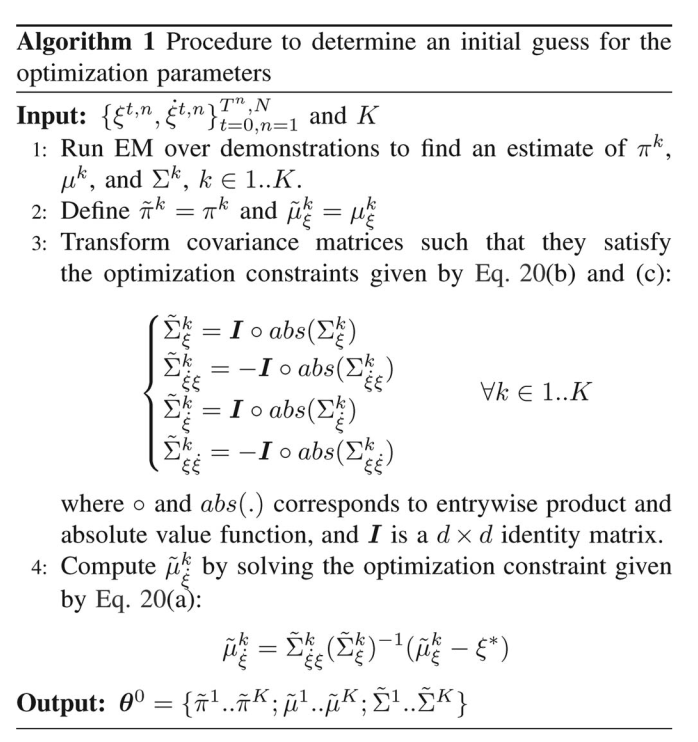

In [6]:
class SEDs(SEDS):

    def __init__(self,attractor,n_mixture):

        assert attractor.ndim==1
        self.attractor = attractor
        self.n_mixture = n_mixture
        self.d = len(attractor)

    def initialize_params(self,y,yd):
        '''
            initializing params(for furthur constrained optimization),
            from the algorithm mentioned in the paper

            parameters
            -----------
            y: state space ,shape - (number of points,self.d)
            yd: derivative of state space - (number of points,self.d)

            Returns
            --------
            priors : shape-(self.n_mixture,)
            means : shape-(self.n_mixture,2*self.d)
            covars : shape-(self.n_mixture,2*self.d,2*self.d)

        '''
        ################################
        #YOUR CODE HERE (you can use the gmr api for EM algorithm)


        ################################

        return priors,means,covars


In [ ]:
#fit the model
attractor = data[0][-1]
n_mixture = 10
model = SEDs(attractor,n_mixture)
model.fit(x,xd)

In [6]:
#starting point for imitation
x0 = data[0][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=5)

In [ ]:

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")


In [ ]:
#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")
streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

In [ ]:
####################
#YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS
####################

# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment7.ipynb**